In [147]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [148]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [149]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Figure description


#### evaluate calculated Omegas

In [150]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seawater
import netCDF4 as nc
import sys
sys.path.append('/data/tjarniko/mocsy')
import mocsy
import gsw
import warnings

#### LOAD OBSERVATIONAL DATA

In [151]:
talk = 2105 * 1e-3
tdic = 2035 * 1e-3
response_tup = mocsy.mvars(temp=10, sal=31, alk=talk, dic=tdic,
                   sil=0, phos=0, patm=1, depth=0, lat=0,
                    optcon='mol/m3', optt='Tinsitu', optp='m',
                    optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
pH,pco2,fco2,co2,hco3,co3,OmegaA_test,OmegaC,BetaD,DENis,p,Tis = response_tup

print(OmegaA_test)

[1.00304085]


In [152]:
infil = np.loadtxt('./Datasets/grl2016_nu.txt')
P = infil[:,8]
T = infil[:,9] #insitu
S = infil[:,10]
dic = infil[:,13]
ta = infil[:,15]
tzero = np.zeros_like(ta)
dens = seawater.dens(S,T,P)
# CONVERT FROM UMOL TO MMOL/M3
dic_conv=dic*dens/1000 * 1e-3
ta_conv = ta*dens/1000 * 1e-3
tpressure = tzero +1 

response_tup = mocsy.mvars(temp=T, sal=S, alk=ta_conv, dic=dic_conv,
                   sil=tzero, phos=tzero, patm=tpressure, depth=P, lat=tzero,
                    optcon='mol/m3', optt='Tinsitu', optp='m',
                    optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
pH,pco2,fco2,co2,hco3,co3,OmegaA_OBS,OmegaC,BetaD,DENis,p,Tis = response_tup

#print(OmegaA)




In [153]:
scrdir = './MODEL_EVAL_scripts/'
OmegaA_MOD_stor = np.zeros([5,860])
for yr in range(2013,2018):

    DICnc = nc.Dataset(scrdir+'/DIC_hindcast201905_GRL_comp_' + str(yr) + '.nc')
    TAnc = nc.Dataset(scrdir+'/TA_hindcast201905_GRL_comp_' + str(yr) + '.nc')
    tempnc = nc.Dataset(scrdir+'/temp_hindcast201905_GRL_comp_' + str(yr) + '.nc')
    salnc = nc.Dataset(scrdir+'/sal_hindcast201905_GRL_comp_' + str(yr) + '.nc')

    DIC = DICnc['model_output']['mod_point'][:]
    TA = TAnc['model_output']['mod_point'][:]
    ttemp  = tempnc['model_output']['mod_point'][:]
    tsal = salnc['model_output']['mod_point'][:]
    
    tsra_psu = tsal*35/35.16504
    ttera_is = gsw.t_from_CT(tsal,ttemp,P)

    response_tup = mocsy.mvars(temp=ttera_is, sal=tsal, alk=TA*1e-3, dic=DIC*1e-3,
                       sil=tzero, phos=tzero, patm=tpressure, depth=P, lat=tzero,
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA_MOD,OmegaC,BetaD,DENis,p,Tis = response_tup
    OmegaA_MOD_stor[yr-2013,:] = OmegaA_MOD

stats for all points reported first, then points where obs dic >1800
year 2013
bias is (mod - obs): 0.18859201332930564; 0.17958081650241842
RMSE: 0.40154953999791876; 0.33694531257015226
WSS: 0.736032030489556; 0.6494218120401012

year 2014
bias is (mod - obs): 0.1715083653004904; 0.14982868969010932
RMSE: 0.3602635510889881; 0.2794927186407919
WSS: 0.788298440827014; 0.7162271698759066

year 2015
bias is (mod - obs): 0.19617211180701066; 0.18625057511593535
RMSE: 0.3962589008556535; 0.33058176610380563
WSS: 0.7409852174358913; 0.6549947495815622



/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.
/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


year 2016
bias is (mod - obs): 0.24239880160760363; 0.22509288260734794
RMSE: 0.4420970032709616; 0.3718166939508938
WSS: 0.7198965455298163; 0.6377233791411849

year 2017
bias is (mod - obs): 0.1790954611358041; 0.17059446014266566
RMSE: 0.3787122163218216; 0.29862741249154084
WSS: 0.7454431869205523; 0.686468613894439



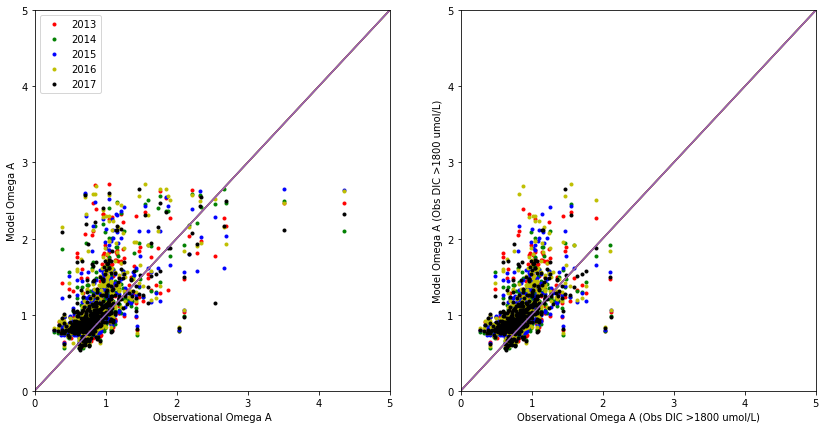

In [154]:
OmegaA_OBS[(OmegaA_MOD >1e19) | (OmegaA_OBS >1e19)] = np.nan

for i in range(0,5):
    OmegaA_MOD = OmegaA_MOD_stor[i,:]
    OmegaA_MOD[(OmegaA_MOD >1e19) | (OmegaA_OBS >1e19)] = np.nan
    OmegaA_MOD_stor[i,:] = OmegaA_MOD
    
    
OmegaA_OBS_1800 = np.copy(OmegaA_OBS)
OmegaA_OBS_1800[dic_conv<1800*1e-3] = np.nan

OmegaA_MOD_stor_1800 = np.copy(OmegaA_MOD_stor) 
for i in range(0,5):
    OmegaA_MOD = OmegaA_MOD_stor_1800[i,:]
    OmegaA_MOD[(OmegaA_MOD >1e19) | (OmegaA_OBS_1800 >1e19) | (dic_conv>1800) ] = np.nan
    OmegaA_MOD_stor_1800[i,:] = OmegaA_MOD
    



fact = 0.5

fig, axs = plt.subplots(1,2, figsize=(14*fact*2, 14*fact), facecolor='w', edgecolor='k')\
#axs = axs.ravel()
cols = ['r','g','b','y','k']

obs = OmegaA_OBS[~np.isnan(OmegaA_OBS)]
obs_1800 = OmegaA_OBS_1800[~np.isnan(OmegaA_OBS_1800)]

print('stats for all points reported first, then points where obs dic >1800')
for i in range(0,5):
    
    mod = OmegaA_MOD_stor[i,:]
    mod = mod[~np.isnan(OmegaA_OBS)]
    axs[0].plot(obs,mod,marker = '.', color = cols[i], linestyle = 'none', label = str(i+2013))
    axs[0].set_xlim([0,5]); axs[0].set_xlabel('Observational Omega A')
    axs[0].set_ylim([0,5]); axs[0].set_ylabel('Model Omega A')
    axs[0].plot([0,5],[0,5])
    axs[0].legend(loc = 'best')
    
    mod_1800 = OmegaA_MOD_stor_1800[i,:]
    mod_1800 = mod_1800[~np.isnan(OmegaA_OBS_1800)]
    
    axs[1].plot(obs_1800,mod_1800,marker = '.', color = cols[i], linestyle = 'none')
    axs[1].set_xlim([0,5]); axs[1].set_xlabel('Observational Omega A (Obs DIC >1800 umol/L)' )
    axs[1].set_ylim([0,5]); axs[1].set_ylabel('Model Omega A (Obs DIC >1800 umol/L)')
    axs[1].plot([0,5],[0,5])
    
    xbar = np.mean(obs)
    bias = (-np.mean(obs) + np.mean(mod))
    RMSE = (np.sqrt(np.sum((mod - obs)**2) /len(obs)))
    WSS = (1-(np.sum((mod - obs)**2)  / np.sum((np.abs(mod - xbar) + np.abs(obs - xbar))**2)))
    
    xbar = np.mean(obs_1800)
    bias_1800 = (-np.mean(obs_1800) + np.mean(mod_1800))
    RMSE_1800 = (np.sqrt(np.sum((mod_1800 - obs_1800)**2) /len(obs_1800)))
    WSS_1800 = (1-(np.sum((mod_1800 - obs_1800)**2)  / np.sum((np.abs(mod_1800 - xbar) + np.abs(obs_1800 - xbar))**2)))

    
    
    print(f'year {i+2013}' ) 
    print(f'bias is (mod - obs): {bias}; {bias_1800}')#'))'') 
    print(f'RMSE: {RMSE}; {RMSE_1800}')
    print(f'WSS: {WSS}; {WSS_1800}')
    print()

In [155]:
# DIC_bias_over1800[index] = (-np.mean(obs) + np.mean(mod))
# DIC_RMSE_over1800[index] = (np.sqrt(np.sum((mod - obs)**2) /len(obs)))
# DIC_WSS_over1800[index] = (1-(np.sum((mod - obs)**2)  / np.sum((np.abs(mod - xbar) + np.abs(obs - xbar))**2)))
# DIC_modstd_over1800[index] = np.std(mod)
# DIC_obsstd_over1800[index] = np.std(obs)

## metrics when removing average TA bias (28 umol/L)

In [156]:
scrdir = './MODEL_EVAL_scripts/'
OmegaA_MOD_stor = np.zeros([5,860])
for yr in range(2013,2018):

    DICnc = nc.Dataset(scrdir+'/DIC_hindcast201905_GRL_comp_' + str(yr) + '.nc')
    TAnc = nc.Dataset(scrdir+'/TA_hindcast201905_GRL_comp_' + str(yr) + '.nc')
    tempnc = nc.Dataset(scrdir+'/temp_hindcast201905_GRL_comp_' + str(yr) + '.nc')
    salnc = nc.Dataset(scrdir+'/sal_hindcast201905_GRL_comp_' + str(yr) + '.nc')

    DIC = DICnc['model_output']['mod_point'][:]
    tabi = np.zeros_like(DIC)
    tabi[:] = 28 
    TA = TAnc['model_output']['mod_point'][:] - tabi
    ttemp  = tempnc['model_output']['mod_point'][:]
    tsal = salnc['model_output']['mod_point'][:]
    
    tsra_psu = tsal*35/35.16504
    ttera_is = gsw.t_from_CT(tsal,ttemp,P)

    response_tup = mocsy.mvars(temp=ttera_is, sal=tsal, alk=TA*1e-3, dic=DIC*1e-3,
                       sil=tzero, phos=tzero, patm=tpressure, depth=P, lat=tzero,
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA_MOD,OmegaC,BetaD,DENis,p,Tis = response_tup
    OmegaA_MOD_stor[yr-2013,:] = OmegaA_MOD

/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.
/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


stats for all points reported first, then points where obs dic >1800
year 2013
bias is (mod - obs): -0.007129147336763952; -0.010503476690470914
RMSE: 0.3393640145791225; 0.26745772204304125
WSS: 0.7789570316292347; 0.7233887595757417

year 2014
bias is (mod - obs): -0.02242459780394024; -0.03828495974286006
RMSE: 0.3032074624881305; 0.22610507264410204
WSS: 0.8260752241529357; 0.7716915955002488

year 2015
bias is (mod - obs): -0.0006868746030801454; -0.005435406332272352
RMSE: 0.328972500882029; 0.2561224140881039
WSS: 0.788630668463262; 0.7331624544098558

year 2016
bias is (mod - obs): 0.042301171654066216; 0.030382918160078765
RMSE: 0.3527432106502392; 0.2773279145738859
WSS: 0.7832642932814082; 0.7307356227382252

year 2017
bias is (mod - obs): -0.017212787522077222; -0.020531439715126165
RMSE: 0.32279539687118397; 0.23327794793500084
WSS: 0.7816426779082529; 0.7538230723386212



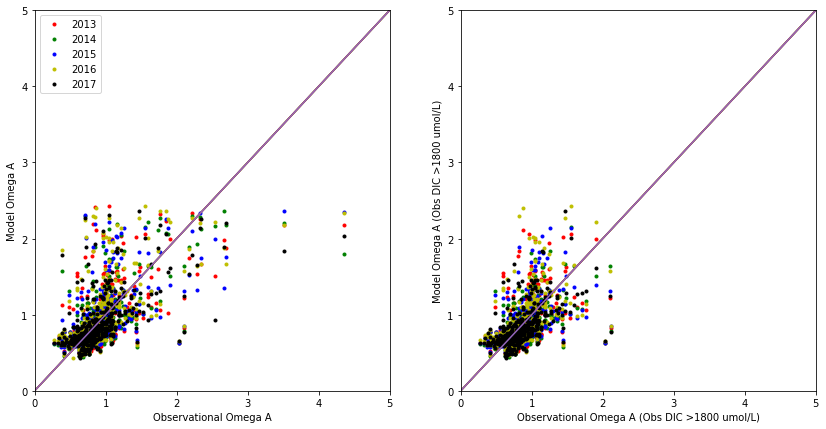

In [157]:
OmegaA_OBS[(OmegaA_MOD >1e19) | (OmegaA_OBS >1e19)] = np.nan

for i in range(0,5):
    OmegaA_MOD = OmegaA_MOD_stor[i,:]
    OmegaA_MOD[(OmegaA_MOD >1e19) | (OmegaA_OBS >1e19)] = np.nan
    OmegaA_MOD_stor[i,:] = OmegaA_MOD
    
    
OmegaA_OBS_1800 = np.copy(OmegaA_OBS)
OmegaA_OBS_1800[dic_conv<1800*1e-3] = np.nan

OmegaA_MOD_stor_1800 = np.copy(OmegaA_MOD_stor) 
for i in range(0,5):
    OmegaA_MOD = OmegaA_MOD_stor_1800[i,:]
    OmegaA_MOD[(OmegaA_MOD >1e19) | (OmegaA_OBS_1800 >1e19) | (dic_conv>1800) ] = np.nan
    OmegaA_MOD_stor_1800[i,:] = OmegaA_MOD
    



fact = 0.5

fig, axs = plt.subplots(1,2, figsize=(14*fact*2, 14*fact), facecolor='w', edgecolor='k')\
#axs = axs.ravel()
cols = ['r','g','b','y','k']

obs = OmegaA_OBS[~np.isnan(OmegaA_OBS)]
obs_1800 = OmegaA_OBS_1800[~np.isnan(OmegaA_OBS_1800)]

print('stats for all points reported first, then points where obs dic >1800')
for i in range(0,5):
    
    mod = OmegaA_MOD_stor[i,:]
    mod = mod[~np.isnan(OmegaA_OBS)]
    axs[0].plot(obs,mod,marker = '.', color = cols[i], linestyle = 'none', label = str(i+2013))
    axs[0].set_xlim([0,5]); axs[0].set_xlabel('Observational Omega A')
    axs[0].set_ylim([0,5]); axs[0].set_ylabel('Model Omega A')
    axs[0].plot([0,5],[0,5])
    axs[0].legend(loc = 'best')
    
    mod_1800 = OmegaA_MOD_stor_1800[i,:]
    mod_1800 = mod_1800[~np.isnan(OmegaA_OBS_1800)]
    
    axs[1].plot(obs_1800,mod_1800,marker = '.', color = cols[i], linestyle = 'none')
    axs[1].set_xlim([0,5]); axs[1].set_xlabel('Observational Omega A (Obs DIC >1800 umol/L)' )
    axs[1].set_ylim([0,5]); axs[1].set_ylabel('Model Omega A (Obs DIC >1800 umol/L)')
    axs[1].plot([0,5],[0,5])
    
    xbar = np.mean(obs)
    bias = (-np.mean(obs) + np.mean(mod))
    RMSE = (np.sqrt(np.sum((mod - obs)**2) /len(obs)))
    WSS = (1-(np.sum((mod - obs)**2)  / np.sum((np.abs(mod - xbar) + np.abs(obs - xbar))**2)))
    
    xbar = np.mean(obs_1800)
    bias_1800 = (-np.mean(obs_1800) + np.mean(mod_1800))
    RMSE_1800 = (np.sqrt(np.sum((mod_1800 - obs_1800)**2) /len(obs_1800)))
    WSS_1800 = (1-(np.sum((mod_1800 - obs_1800)**2)  / np.sum((np.abs(mod_1800 - xbar) + np.abs(obs_1800 - xbar))**2)))

    
    
    print(f'year {i+2013}' ) 
    print(f'bias is (mod - obs): {bias}; {bias_1800}')#'))'') 
    print(f'RMSE: {RMSE}; {RMSE_1800}')
    print(f'WSS: {WSS}; {WSS_1800}')
    print()

array([0.7895135 ,        nan, 0.70075265,        nan, 0.77696098,
              nan, 0.72044407,        nan, 0.6816638 ,        nan,
       0.83261184,        nan, 0.7922237 ,        nan, 0.84372277,
              nan, 0.89519801,        nan, 1.07390427,        nan,
       1.43476334,        nan,        nan,        nan,        nan,
              nan,        nan, 0.72907696,        nan, 0.56098316,
              nan, 0.55640329,        nan, 0.69658309,        nan,
       0.71944403,        nan,        nan,        nan,        nan,
              nan, 0.84039702,        nan, 0.9197938 ,        nan,
       0.95900223,        nan, 0.87121039,        nan,        nan,
              nan, 0.64127752,        nan, 0.71198755,        nan,
       0.68073292,        nan, 0.88066233,        nan, 0.84660457,
              nan, 0.74391817,        nan, 0.76062473,        nan,
       0.65440253,        nan, 0.82587214,        nan, 0.85601491,
              nan, 1.05267593,        nan, 1.08347018,        